In [112]:
!pip3 install foolbox==3.1.1

import matplotlib.pyplot as plt
import requests
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import foolbox as fb
import tensorflow as tf

img_path = 'image.png'

## Pobranie obrazu

In [113]:
img_data = requests.get("https://c.pxhere.com/images/a3/c2/f0f92c545a6299eb6563f3213b04-1616104.jpg!d").content
#img_data = requests.get("https://upload.wikimedia.org/wikipedia/commons/0/09/Tux%2C_gray%EF%BC%8Fgrey_background.png").content
with open(img_path, 'wb') as handler:
    handler.write(img_data)

## Klasyfikacja obrazu

Predicted: [('n09428293', 'seashore', 0.29185417), ('n09421951', 'sandbar', 0.2565445), ('n04371774', 'swing', 0.15451878)]


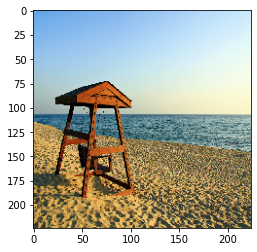

In [114]:
model = ResNet50(weights='imagenet')

img = image.load_img(img_path, target_size=(224, 224))

plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

## Konwersja obrazów do odpowiedniego formatu

In [115]:
preprocessing = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])
bounds = (0, 255)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

fmodel = fmodel.transform_bounds((0, 1))

## Foolbox: pobranie przykładowych obrazów

In [116]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

#plt.imshow(images[0])
print("images.shape: ", images.shape)

print("labels.shape: ", labels.shape)
tf.print("labels", labels)

images.shape:  (16, 224, 224, 3)
labels.shape:  (16,)
labels [243 559 438 ... 471 129 99]


## Próba ataku na własnym obrazku

In [117]:
attack = fb.attacks.L2CarliniWagnerAttack(steps=100)

# docelowa etykieta w odpowiednim formacie
new_label = np.asarray([243]).astype(np.int32)
print(new_label.shape)

# preprocessing obrazu
new_img = tf.keras.preprocessing.image.img_to_array(img)
new_img = np.asarray([new_img])
new_img = tf.convert_to_tensor(new_img, dtype=tf.float32)
print(new_img.shape)

# konwersja z formatu 0-255 do 0-1
new_img /= 255.0

print("DANE WCZYTANEGO OBRAZU:")
print(new_img)

print("DANE OBRAZU ZE ZBIORU OBRAZÓW Z FOOLBOX:")
print(images[0])

# shape, typ zmiennej, kodowanie pikseli zgadzają się z tym co jest w images[]

#raw, clipped, is_adv = attack(fmodel, new_img, new_label, epsilons=0.03)

(1,)
(1, 224, 224, 3)
DANE WCZYTANEGO OBRAZU:
tf.Tensor(
[[[[0.40392157 0.6431373  0.8901961 ]
   [0.39607844 0.64705884 0.8901961 ]
   [0.40392157 0.6431373  0.8980392 ]
   ...
   [0.79607844 0.9098039  0.98039216]
   [0.7921569  0.90588236 0.9764706 ]
   [0.8        0.9137255  0.9843137 ]]

  [[0.40392157 0.6431373  0.8901961 ]
   [0.39607844 0.64705884 0.8901961 ]
   [0.4        0.6392157  0.89411765]
   ...
   [0.79607844 0.9098039  0.98039216]
   [0.8        0.9137255  0.9843137 ]
   [0.8        0.9137255  0.9843137 ]]

  [[0.40392157 0.6431373  0.8901961 ]
   [0.39215687 0.6431373  0.8862745 ]
   [0.40392157 0.6431373  0.8980392 ]
   ...
   [0.79607844 0.9098039  0.972549  ]
   [0.79607844 0.9098039  0.972549  ]
   [0.8        0.9137255  0.9764706 ]]

  ...

  [[0.29411766 0.32156864 0.2509804 ]
   [0.24313726 0.30980393 0.27058825]
   [0.22352941 0.26666668 0.21176471]
   ...
   [0.7372549  0.62352943 0.34901962]
   [0.93333334 0.7176471  0.39607844]
   [0.6431373  0.5686275  0.

## Atak na obrazach z datasetu Foolbox

In [118]:
epsilons = [
  0.0,
  #0.0002,
  0.0005,
  #0.0008,
  0.001,
  #0.0015,
  0.002,
  #0.003,
  0.01,
  #0.1,
  0.3,
  0.5,
  1.0,
  10
]

raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

In [119]:
print(is_adv)
print(is_adv.shape)
print(raw[0].shape)
print(clipped[0].shape)

tf.Tensor(
[[False False False False False False False  True False False False False
  False False  True False]
 [False False False False False False False  True False False False False
  False False  True False]
 [False False False False False False False  True False False False False
  False False  True False]
 [False False False False False False False  True False False False False
  False False  True False]
 [False False False False False False False  True False False False False
  False False  True False]
 [False False  True False False False  True  True False False False  True
   True False  True False]
 [ True  True  True  True False False  True  True False False False  True
   True False  True  True]
 [ True  True  True  True  True  True  True  True  True  True False  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]], shape=(9, 16), dtype=bool)
(9, 16)
(16, 224, 224, 3)
(16, 224, 224, 3)


Oznaczenia zwracanych wartości:

[źródło](https://foolbox.jonasrauber.de/guide/getting-started.html#attacking-the-model)

The attack returns three tensors.

1. The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
2. The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
3. The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.

## Wizualizacja oryginalnych i zaatakowanych obrazów

Trzy ostatnie wartości epsilon

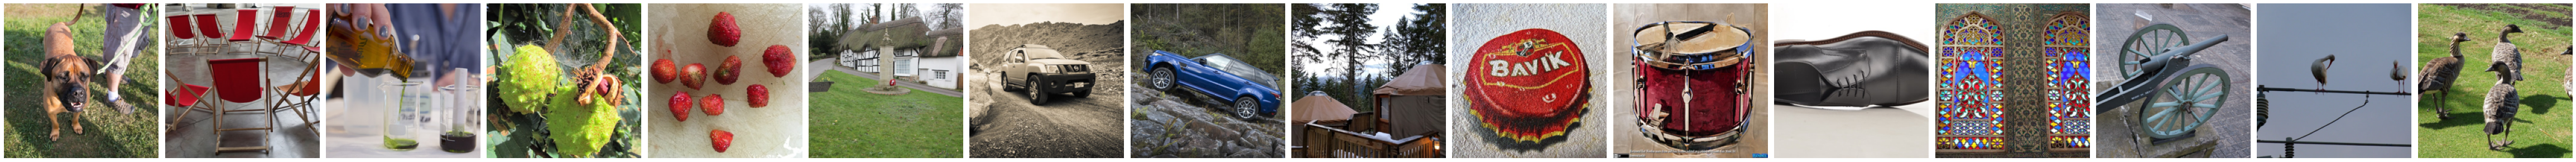

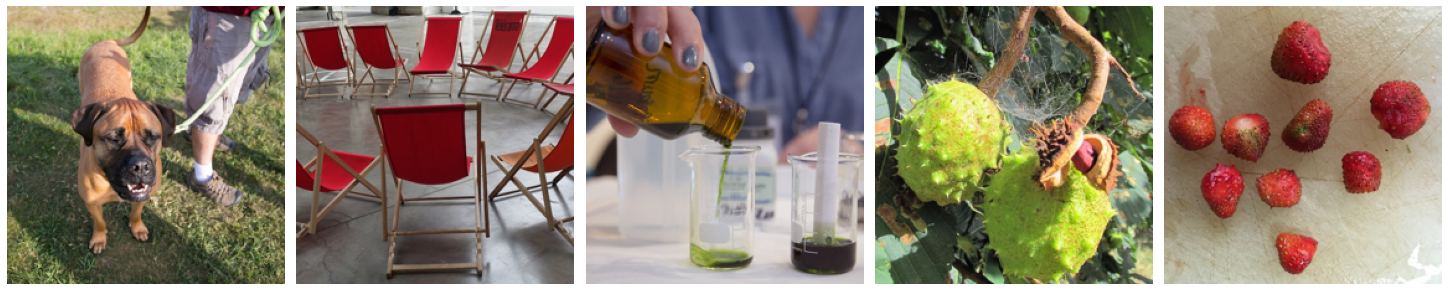

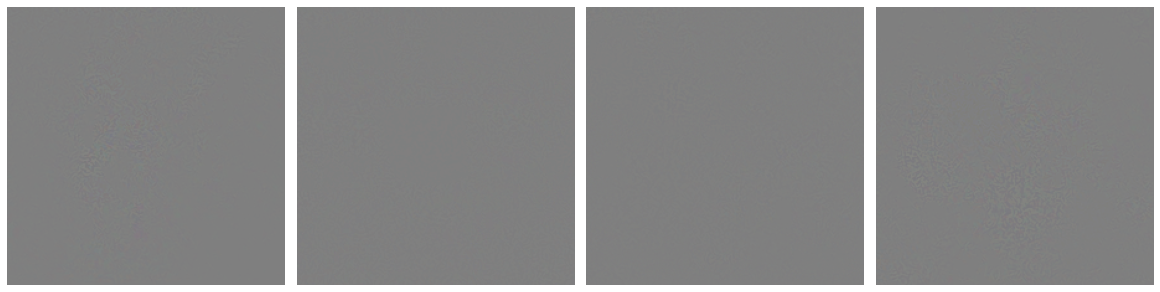

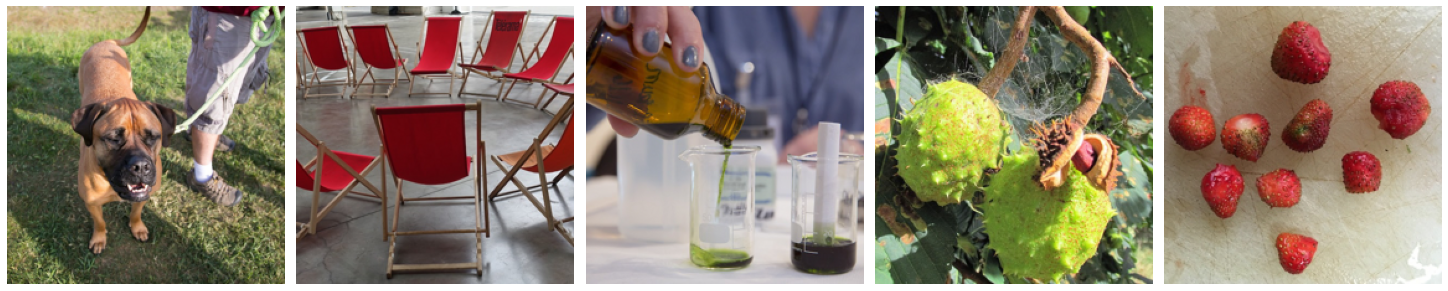

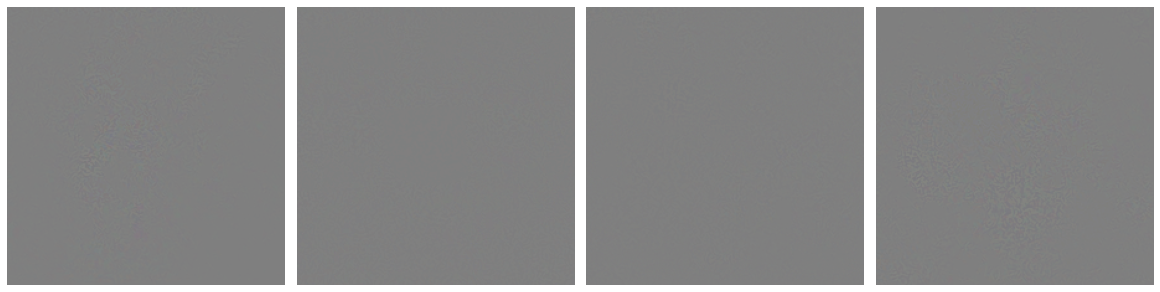

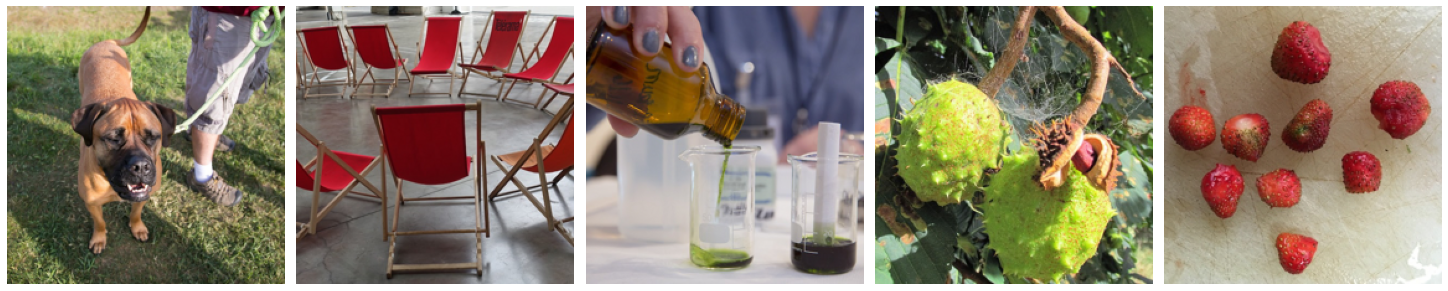

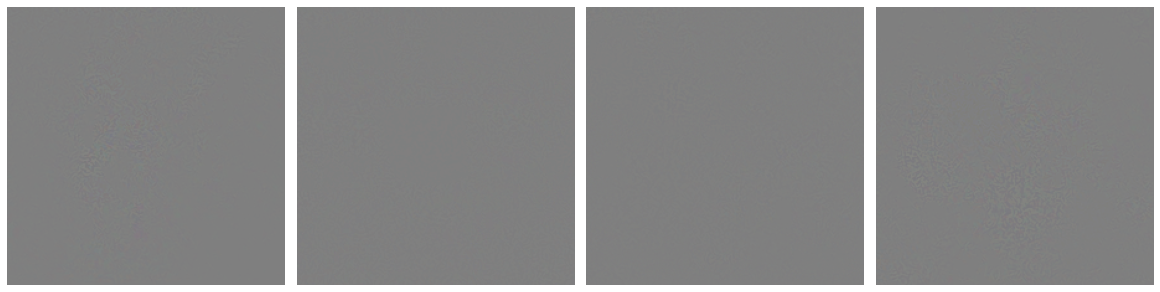

In [120]:
fb.plot.images(images, scale=4.)
for r in clipped[-3:]:
  fb.plot.images(r[0:5], scale=4.)
  fb.plot.images(r - images, n=4, bounds=(-0.1, 0.1), scale=4.)

## Nałożenie szumu na obrazy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


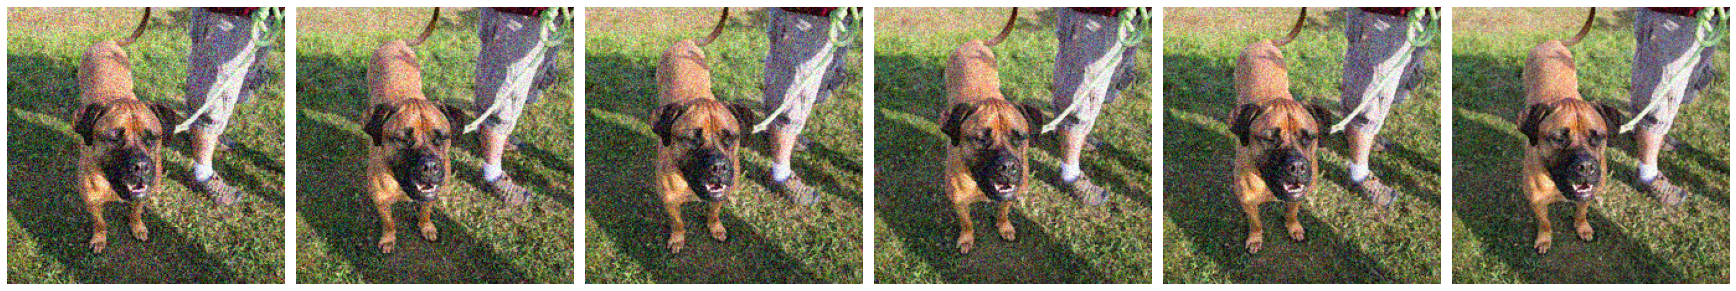

In [148]:
noisy_images = []
variances_to_try = [0.015, 0.013, 0.012, 0.0105, 0.01, 0.007]

for variance in variances_to_try:
  idx,row,col,ch=raw[0].shape
  mean = 0
  sigma = variance**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = raw[0][0] + gauss

  noisy_images.append(noisy)

noisy_images = np.asarray(noisy_images)
noisy_images = tf.convert_to_tensor(noisy_images, dtype=tf.float32)
print(noisy_images.shape)

fb.plot.images(noisy_images, scale=4.)

## Test ataku na zaszumionym obrazie

In [149]:
results = []
labels_noisy_test =  tf.convert_to_tensor([labels[0]] * len(noisy_images))
# labels_noisy_test = np.asarray(labels_noisy_test)
print(labels_noisy_test)
print(noisy_images.shape)

gauss_raw, gauss_clipped, gauss_is_adv = attack(fmodel, noisy_images, labels_noisy_test, epsilons=epsilons)

tf.Tensor([243 243 243 243 243 243], shape=(6,), dtype=int64)
(6, 224, 224, 3)


In [155]:
# 9 wartości epsilon * 5 obrazków

print(gauss_is_adv)

#for g_is_adv in gauss_is_adv:
 # print(g_is_adv)
  #print(1 - g_is_adv.float32().mean(axis=-1))

tf.Tensor(
[[ True False  True  True False  True]
 [ True False  True  True False  True]
 [ True False  True  True False  True]
 [ True False  True  True False  True]
 [ True False  True  True False  True]
 [ True False  True  True False  True]
 [ True False  True  True False  True]
 [ True False  True  True False  True]
 [ True False False  True False  True]], shape=(9, 6), dtype=bool)
